In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchmetrics.functional as evafunc
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
import segmentation_models_pytorch as smp
import os
from PIL import Image
import vtk
from vtk.util import numpy_support

c:\Users\manjw\.conda\envs\dataEngineering\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
c:\Users\manjw\.conda\envs\dataEngineering\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 自定义数据集类
class SpineWeb15(Dataset):
    def __init__(self, data_path,transform1=None,transform2=None):
        self.data_path = data_path
        self.transform1 = transform1
        self.transform2 = transform2
        
    def __len__(self):
        file_list = os.listdir(self.data_path)  # 列出文件夹中的所有文件和文件夹
        file_count = len(file_list)  # 获取文件数量
        return file_count
    
    def __getitem__(self, index):
        metadata = np.load(self.data_path+str(index)+".npy")
        image = metadata[0]
        label = metadata[1]

        # 找到数组中的最小值和最大值
        min_value = np.min(image)
        max_value = np.max(image)

        # # 将数组元素限制在0到255之间（类似于归一化）
        image = (image - min_value) * (255 / (max_value - min_value))

        image_data = Image.fromarray(image)
        label_data = Image.fromarray(label)
        # image_data = torch.from_numpy(image).float()
        # label_data = torch.from_numpy(label).float()
        
        if self.transform1:
            image_data = self.transform1(image_data)
        if self.transform2:
            label_data = self.transform2(label_data)
        return image_data, label_data
    
def calculate_pixel_accuracy(prediction, target):
    # 将预测结果和目标标签进行逐像素比较，并计算正确预测像素的比例
    correct_pixels = (prediction == target).sum().item()
    total_pixels = target.numel()
    return correct_pixels, total_pixels

def calculate_iou(prediction, target):
    intersection = torch.logical_and(prediction, target).sum()
    union = torch.logical_or(prediction, target).sum()
    iou = intersection / union
    return iou.item()

def calculate_dice(prediction, target):
    intersection = torch.logical_and(prediction, target).sum()
    dice = (2 * intersection) / (prediction.sum() + target.sum())
    return dice.item()

def contains_only_0s_and_1s(tensor):
    return ((tensor == 0) | (tensor == 1)).all()



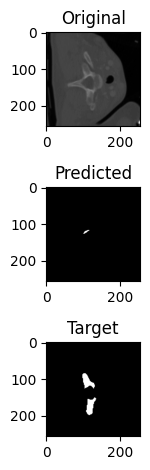

Best Test IoU: 0.0592, Best Test Dice: 0.1038 Best Test Acc: 0.9570


In [3]:
# -------------------------------------------------------
# Load the NN model and generate the vtk file
# -------------------------------------------------------

model = smp.UnetPlusPlus(encoder_name='timm-resnest200e', encoder_depth=5, encoder_weights="imagenet", decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type="scse", in_channels=1, classes=1, activation=None, aux_params=None)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


test_path = "./dataset/Spineweb_dataset15/test_1/"

transform = transforms.Compose([
    # transforms.ToPILImage(),  # 转换为 PIL 图像对象
    transforms.Resize((256, 256)),  # 调整大小为 128x128
    transforms.ToTensor()  # 转换为张量
])

# 加载已保存的模型参数
checkpoint_path = "./model/UNet++Resnest200_checkpoint.pth"  # 模型文件路径
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

# 设置模型为推理模式
model.eval()
batch_size = 8
confidence = 0.9
poster_threshold = 200
testset = SpineWeb15(data_path=test_path, transform1=transform,transform2=transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

total_iou_test = 0.0
total_dice_test = 0.0
total_acc_test = 0.0
total_correct_pixels_test = 0
total_pixels_test = 0

# The slice list to store every predicted result
predict_list = []
target_list = []

# test set results
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets = targets * 255
        targets[targets <= poster_threshold] = 0
        targets[targets > poster_threshold] = 1
        outputs = model(inputs)
        # squeeze the dimension that pytorch add for channels
        outputs = outputs.squeeze(1)     # tensor size ([16,128,128])
        targets = targets.squeeze(1)
        outputs = torch.sigmoid(outputs)
        # process the result, bigger than 0.5 is reliable
        predicted = (outputs > confidence).float()     # tensor size ([16,128,128])
        
        # print("predicted max:",torch.max(predicted))
        # print("predicted min:",torch.min(predicted))
        # print("target max:",torch.max(targets))
        # print("target min:",torch.min(targets))
        # print("length of targets and predicted:",len(targets),len(predicted))
        # print("Only have 0 or 1:",contains_only_0s_and_1s(predicted),contains_only_0s_and_1s(targets))
        
        # print(predicted.shape)
        temp_predicted = predicted.cpu().numpy()
        temp_targets = targets.cpu().numpy()
        predict_list.append(temp_predicted)
        target_list.append(temp_targets)

        intersection = torch.logical_and(predicted, targets).sum((1, 2))
        union = torch.logical_or(predicted, targets).sum((1, 2))
        iou = (intersection / (union + 1e-7))  # 平均每个样本的IoU
        dice = (2 * intersection / (predicted.sum((1, 2)) + targets.sum((1, 2))+1e-7))  # 平均每个样本的Dice Coefficient


        batch_correct_pixels,batch_total_pixels = calculate_pixel_accuracy(predicted, targets)
        total_iou_test += torch.sum(iou).item()
        total_dice_test += torch.sum(dice).item()
        total_correct_pixels_test += batch_correct_pixels
        total_pixels_test += batch_total_pixels

inputs_npimage = inputs.squeeze(1)[0].detach().cpu().numpy()
predicted_npimage = predicted[0].detach().cpu().numpy()
targets_npimage = targets[0].detach().cpu().numpy()
fig, axes = plt.subplots(3, 1)
axes[0].imshow(inputs_npimage, cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(predicted_npimage, cmap='gray')
axes[1].set_title('Predicted')
axes[2].imshow(targets_npimage, cmap='gray')
axes[2].set_title('Target')
plt.tight_layout()
plt.show()

test_iou = total_iou_test / len(testset)
test_dice = total_dice_test / len(testset)
test_acc = total_correct_pixels_test / total_pixels_test

# output the result, the result may vary a little due to the resize function in transform
print(f"Best Test IoU: {test_iou:.4f}, Best Test Dice: {test_dice:.4f} Best Test Acc: {test_acc:.4f}")

# stack the predicted and targets lists
stack_predicts = np.concatenate(predict_list,axis=0)      # shape: (365,128,128)
stack_targets = np.concatenate(target_list,axis=0)      # shape: (365,128,128)

# empty the cache
torch.cuda.empty_cache()

In [4]:
# -------------------------------------------------------
# Generate the predict 3D model
# -------------------------------------------------------
dims = stack_predicts.shape    # only has 0 and 1
vtk_data = vtk.vtkImageData()
vtk_data.SetDimensions(dims[1], dims[2], dims[0])  # 注意VTK使用的顺序是Z, Y, X
vtk_data.SetSpacing(1.0, 1.0, 1.0)  # 设置体素的尺寸，这里假设体素的尺寸为1.0
vtk_data.SetOrigin(0.0, 0.0, 0.0)  # 设置数据的原点，可以根据需求调整
vtk_data.AllocateScalars(vtk.VTK_UNSIGNED_CHAR, 1)  # 将数据类型设为vtk.VTK_UNSIGNED_CHAR

# 将NumPy数组中的数据复制到vtkImageData中，并进行数据类型转换
vtk_array = numpy_support.numpy_to_vtk(stack_predicts.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
vtk_array.SetName("Scalars")  # 设置 VTK 数组的名称
vtk_data.GetPointData().SetScalars(vtk_array)  # SetScalars instead of GetScalars

# 创建体积渲染效果
volume_mapper = vtk.vtkGPUVolumeRayCastMapper()  # 使用GPU进行体积渲染（需要支持OpenGL的显卡）
volume_mapper.SetInputData(vtk_data)

# 创建体积渲染属性
volume_property = vtk.vtkVolumeProperty()
volume_property.ShadeOn()
volume_property.SetInterpolationTypeToLinear()

# 创建颜色传输函数，将1的体素设置为实体部分的颜色
color_transfer_function = vtk.vtkColorTransferFunction()
color_transfer_function.AddRGBPoint(0, 0.0, 0.0, 0.0)  # 设置0的颜色为黑色
color_transfer_function.AddRGBPoint(1, 1.0, 1.0, 1.0)  # 设置1的颜色为红色
volume_property.SetColor(color_transfer_function)

# 创建不透明度传输函数，将1的体素设置为完全不透明，0的体素设置为完全透明
opacity_transfer_function = vtk.vtkPiecewiseFunction()
opacity_transfer_function.AddPoint(0, 0.0)  # 设置0的透明度为完全透明
opacity_transfer_function.AddPoint(1, 1.0)  # 设置1的透明度为完全不透明
volume_property.SetScalarOpacity(opacity_transfer_function)

# 创建vtkVolume
volume = vtk.vtkVolume()
volume.SetMapper(volume_mapper)
volume.SetProperty(volume_property)

# 创建渲染器和渲染窗口，并将可视化管道添加到渲染器中，以在屏幕上显示可视化结果：
renderer = vtk.vtkRenderer()
renderer.AddVolume(volume)

render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

renderer.ResetCamera()
render_window.Render()

interactor.Start()

# write and save the vtk voxel file
writer = vtk.vtkDataSetWriter()
writer.SetFileName("./3d/predict_voxels_256.vtk")
writer.SetInputData(vtk_data)
writer.Write()

1

In [5]:
# -------------------------------------------------------
# Generate the target(label) 3D model
# -------------------------------------------------------
stack_targets = np.array(stack_targets).astype(np.int32)
dims = stack_targets.shape    # only has 0 and 1
vtk_data = vtk.vtkImageData()
vtk_data.SetDimensions(dims[1], dims[2], dims[0])  # 注意VTK使用的顺序是Z, Y, X  (365,128,128)
vtk_data.SetSpacing(1.0, 1.0, 1.0)  # 设置体素的尺寸，这里假设体素的尺寸为1.0
vtk_data.SetOrigin(0.0, 0.0, 0.0)  # 设置数据的原点，可以根据需求调整
vtk_data.AllocateScalars(vtk.VTK_UNSIGNED_CHAR, 1)  # 将数据类型设为vtk.VTK_UNSIGNED_CHAR

# 将NumPy数组中的数据复制到vtkImageData中，并进行数据类型转换
vtk_array = numpy_support.numpy_to_vtk(stack_targets.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
vtk_array.SetName("Scalars")  # 设置 VTK 数组的名称
vtk_data.GetPointData().SetScalars(vtk_array)  # SetScalars instead of GetScalars

# 创建体积渲染效果
volume_mapper = vtk.vtkGPUVolumeRayCastMapper()  # 使用GPU进行体积渲染（需要支持OpenGL的显卡）
volume_mapper.SetInputData(vtk_data)

# 创建体积渲染属性
volume_property = vtk.vtkVolumeProperty()
volume_property.ShadeOn()
volume_property.SetInterpolationTypeToLinear()

# 创建颜色传输函数，将1的体素设置为实体部分的颜色
color_transfer_function = vtk.vtkColorTransferFunction()
color_transfer_function.AddRGBPoint(0, 0.0, 0.0, 0.0)  # 设置0的颜色为黑色
color_transfer_function.AddRGBPoint(1, 1.0, 1.0, 1.0)  # 设置1的颜色为红色
volume_property.SetColor(color_transfer_function)

# 创建不透明度传输函数，将1的体素设置为完全不透明，0的体素设置为完全透明
opacity_transfer_function = vtk.vtkPiecewiseFunction()
opacity_transfer_function.AddPoint(0, 0.0)  # 设置0的透明度为完全透明
opacity_transfer_function.AddPoint(1, 1.0)  # 设置1的透明度为完全不透明
volume_property.SetScalarOpacity(opacity_transfer_function)

# 创建vtkVolume
volume = vtk.vtkVolume()
volume.SetMapper(volume_mapper)
volume.SetProperty(volume_property)

# 创建渲染器和渲染窗口，并将可视化管道添加到渲染器中，以在屏幕上显示可视化结果：
renderer = vtk.vtkRenderer()
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

# 创建vtkRenderWindowInteractor并将其与vtkRenderWindow关联
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)

# 将vtkVolume添加到vtkRenderer中
renderer.AddVolume(volume)

render_window.SetSize(800, 600)
render_window.Render()

interactor.Start()

# write and save the vtk voxel file
writer = vtk.vtkDataSetWriter()
writer.SetFileName("./3d/target_voxels_256.vtk")
writer.SetInputData(vtk_data)
writer.Write()

1

In [6]:
# -------------------------------------------------------
# Evaluation
# -------------------------------------------------------